In [1]:
import pandas as pd
import numpy as np
from PIL import Image, ImageEnhance
import os
import io

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from tqdm import tqdm

import tensorflow as tf
import keras



In [2]:
# Load our wiki art csv
verified_df = pd.read_csv("verified_artwork_data.csv")

In [3]:
verified_df.head()

,id,title,url,artistUrl,artistName,artistId,completitionYear,width,image,height,movement,file_path
0,57728a68edc2cb388010fa7e,Adelina Morton,NaN,joshua-johnson,Joshua Johnson,57726e02edc2cb3880b55dba,1810.0,496,https://uploads5.wikiart.org/images/joshua-joh...,600,naive_art,downloaded_images_wikiart\naive_art\57728a68ed...
1,57728a68edc2cb388010fa90,BENJAMIN FRANKLIN YOE AND SON,NaN,joshua-johnson,Joshua Johnson,57726e02edc2cb3880b55dba,1810.0,483,https://uploads2.wikiart.org/images/joshua-joh...,600,naive_art,downloaded_images_wikiart\naive_art\57728a68ed...
2,57728a69edc2cb388010faa0,Edward and Sarah Rutter,NaN,joshua-johnson,Joshua Johnson,57726e02edc2cb3880b55dba,1805.0,450,https://uploads4.wikiart.org/images/joshua-joh...,507,naive_art,downloaded_images_wikiart\naive_art\57728a69ed...
3,57728a69edc2cb388010fab0,Family Group,NaN,joshua-johnson,Joshua Johnson,57726e02edc2cb3880b55dba,1800.0,750,https://uploads3.wikiart.org/images/joshua-joh...,483,naive_art,downloaded_images_wikiart\naive_art\57728a69ed...
4,57728a69edc2cb388010fac0,Girl Wearing a Bonnet,NaN,joshua-johnson,Joshua Johnson,57726e02edc2cb3880b55dba,1810.0,504,https://uploads3.wikiart.org/images/joshua-joh...,600,naive_art,downloaded_images_wikiart\naive_art\57728a69ed...


In [5]:
verified_df['movement'].value_counts()

movement
early_renaissance         466
abstract_expressionism    459
post_impressionism        458
minimalism                453
impressionism             444
expressionism             440
surrealism                434
high_renaissance          433
northern_renaissance      426
cubism                    413
pop_art                   392
fauvism                   361
baroque                   351
romanticism               336
mannerism                 327
art_informel              319
modernism                 301
rococo                    287
contemporary              280
american_realism          272
neoclassicism             272
art_nouveau               256
naive_art                 243
symbolism                 234
ukiyo_e                   230
art_deco                  147
neo_romantic               80
Name: count, dtype: int64

### Image Preprocessing
- Resizing to standard sizes
- Convert floating point arrays
- Normalize 
- Augment the images to address class imbalance

In [7]:
def check_image_sizes(df):
    """
    Checks all unique image sizes in the dataset using existing file_paths
    
    Args:
        df: DataFrame containing 'file_path' column
        
    Returns:
        set: Set of unique (width, height) tuples found in the dataset
    """
    image_sizes = set()
    
    print("Checking image sizes...")
    for _, row in tqdm(df.iterrows()):
        try:
            with Image.open(row['file_path']) as img:
                image_sizes.add(img.size)
        except Exception as e:
            print(f"Error processing {row['file_path']}: {str(e)}")
    

    
    return image_sizes

# Run the check
size_list = check_image_sizes(verified_df)
print("\nTotal unique sizes:", len(size_list))

Checking image sizes...


9114it [00:02, 4140.99it/s]


Total unique sizes: 2543


In [9]:
def letterbox_resize(image, target_size):
    """
    Resize an image to a square target size while maintaining aspect ratio using letterboxing.
    """
    w, h = image.size
    ratio = min(target_size / w, target_size / h)  # Maintain aspect ratio without shrinking too much
    
    new_w = int(w * ratio)
    new_h = int(h * ratio)
    
    # Resize the image
    resized = image.resize((new_w, new_h), Image.LANCZOS)
    
    # Create a black square image of target size
    new_image = Image.new('RGB', (target_size, target_size), (0, 0, 0))
    
    # Calculate padding
    x_offset = (target_size - new_w) // 2
    y_offset = (target_size - new_h) // 2
    
    # Paste the resized image into the center of the black background
    new_image.paste(resized, (x_offset, y_offset))
    
    return new_image

In [10]:
def process_images(df, target_size=256, output_dir='resized_imgs'):
    """
    Process all images in the DataFrame, resize them, and save to output directory.
    
    Args:
        df: DataFrame containing 'file_path' column
        target_size: Size for the square output images (default: 256)
        output_dir: Directory to save resized images (default: 'resized_imgs')
    
    Returns:
        DataFrame with updated file_paths
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Create a copy of the DataFrame to avoid modifying the original
    df = df.copy()
    
    # Keep track of any failures
    failed_processes = []
    
    print(f"Processing {len(df)} images...")
    
    # Process each image with progress bar
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        try:
            # Load the image
            with Image.open(row['file_path']) as img:
                # Resize image
                resized_img = letterbox_resize(img, target_size)
                
                # Get original filename from path and create new path
                filename = os.path.basename(row['file_path'])
                new_path = os.path.join(output_dir, filename)
                
                # Save the resized image
                resized_img.save(new_path, quality=95)  
                
                # Update DataFrame with new path
                df.loc[idx, 'file_path'] = new_path
                
        except Exception as e:
            failed_processes.append({
                'original_path': row['file_path'],
                'error': str(e)
            })
            print(f"\nError processing {row['file_path']}: {e}")
    
    # Print summary
    print("\nProcessing Summary:")
    print(f"Total images processed: {len(df) - len(failed_processes)}")
    print(f"Failed processes: {len(failed_processes)}")
    
    if failed_processes:
        print("\nFailed processes details:")
        for fail in failed_processes:
            print(f"Path: {fail['original_path']}")
            print(f"Error: {fail['error']}")
            print("-" * 50)
    
    # Verify all images in the output directory are the correct size
    print("\nVerifying output images...")
    incorrect_sizes = []
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        if os.path.exists(row['file_path']):
            with Image.open(row['file_path']) as img:
                if img.size != (target_size, target_size):
                    incorrect_sizes.append(row['file_path'])
    
    if incorrect_sizes:
        print(f"\nWarning: Found {len(incorrect_sizes)} images with incorrect size")
        
    return df

# Process all images
verified_df = process_images(verified_df, target_size=256)

Processing 9114 images...


100%|██████████| 9114/9114 [00:58<00:00, 154.86it/s]



Processing Summary:
Total images processed: 9114
Failed processes: 0

Verifying output images...


100%|██████████| 9114/9114 [01:23<00:00, 108.57it/s]


In [12]:
# Check sizes after processing
size_list = check_image_sizes(verified_df) 
print("\nTotal unique sizes:", len(size_list))

Checking image sizes...


9114it [00:02, 4271.82it/s]


Total unique sizes: 1


In [13]:
# Checking new file path
verified_df['file_path'].head()

0    resized_imgs\57728a68edc2cb388010fa7e.jpg
1    resized_imgs\57728a68edc2cb388010fa90.jpg
2    resized_imgs\57728a69edc2cb388010faa0.jpg
3    resized_imgs\57728a69edc2cb388010fab0.jpg
4    resized_imgs\57728a69edc2cb388010fac0.jpg
Name: file_path, dtype: object

In [14]:
# Convert to floating point and normalize
def load_and_normalize_image(file_path):
    """
    Load image from file_path, convert to float32 array and normalize to [0, 1] range
    
    Args:
        file_path (str): Path to the image file
        
    Returns:
        numpy.ndarray: Normalized image array of shape (height, width, 3) in float32
    """
    # Load image
    img = Image.open(file_path)
    
    # Convert to RGB if not already
    if img.mode != 'RGB':
        img = img.convert('RGB')
    
    # Convert to numpy array and change type to float32
    img_array = np.array(img, dtype=np.float32)
    
    # Normalize to [0, 1] range
    img_array = img_array / 255.0
    
    return img_array

# Apply to the DataFrame to create a new column with normalized arrays
verified_df['image_array'] = verified_df['file_path'].apply(load_and_normalize_image)

In [16]:
# Get class distribution
class_counts = verified_df['movement'].value_counts()
target_count = 400

def augment_and_save_image(img_array, original_path, num_augmentations):
    """
    Create and save augmented versions of an image using TensorFlow and PIL
    while preserving key movement characteristics
    """
    new_paths = []
    base_name = os.path.splitext(os.path.basename(original_path))[0]
    ext = os.path.splitext(original_path)[1]
    
    if num_augmentations <= 0:
        return new_paths
        
    # Convert numpy array to PIL Image
    img = Image.fromarray((img_array * 255).astype(np.uint8))
    print(f"\nProcessing image: {base_name}")
    print(f"Initial image mean pixel value: {np.mean(img_array):.3f}")
    
    # Define augmentation ranges - keeping conservative to preserve movement
    brightness_range = (0.9, 1.1)
    contrast_range = (0.9, 1.1)
    saturation_range = (0.95, 1.05)
    hue_range = (-0.05, 0.05)
    
    for i in range(num_augmentations):
        print(f"\nAugmentation {i+1}:")
        
        # Convert PIL image to TensorFlow tensor
        tf_img = tf.convert_to_tensor(np.array(img))
        tf_img = tf.cast(tf_img, tf.float32) / 255.0
        tf_img = tf.expand_dims(tf_img, 0)  # Add batch dimension
        
        # Random horizontal flip
        if np.random.random() < 0.5:
            tf_img = tf.image.flip_left_right(tf_img)
            print("Applied horizontal flip")
        
        # Apply color transformations using TensorFlow
        # Random brightness
        tf_img = tf.image.random_brightness(
            tf_img, 
            max_delta=(brightness_range[1] - 1.0)
        )
        
        # Random contrast
        tf_img = tf.image.random_contrast(
            tf_img,
            lower=contrast_range[0],
            upper=contrast_range[1]
        )
        
        # Random saturation
        tf_img = tf.image.random_saturation(
            tf_img,
            lower=saturation_range[0],
            upper=saturation_range[1]
        )
        
        # Random hue
        tf_img = tf.image.random_hue(
            tf_img,
            max_delta=hue_range[1]
        )
        
        # Ensure values are in valid range
        tf_img = tf.clip_by_value(tf_img, 0.0, 1.0)
        
        # Convert back to numpy and remove batch dimension
        aug_array = tf_img[0].numpy()
        
        # Random rotation using PIL
        aug_img = Image.fromarray((aug_array * 255).astype(np.uint8))
        rotation = np.random.uniform(-10, 10)
        aug_img = aug_img.rotate(rotation, resample=Image.BICUBIC, fillcolor=0)
        print(f"Applied rotation: {rotation:.1f} degrees")
        
        # Convert to numpy for cropping
        aug_array = np.array(aug_img)
        print(f"After color transforms: mean={np.mean(aug_array):.3f}, min={np.min(aug_array)}, max={np.max(aug_array)}")
        
        # Random crop (80% of original size)
        h, w = aug_array.shape[:2]
        crop_size = int(min(h, w) * 0.8)
        start_h = np.random.randint(0, h - crop_size + 1)
        start_w = np.random.randint(0, w - crop_size + 1)
        aug_array = aug_array[start_h:start_h+crop_size, start_w:start_w+crop_size]
        print(f"After cropping: mean={np.mean(aug_array):.3f}, min={np.min(aug_array)}, max={np.max(aug_array)}")
        
        # Resize to standard size
        aug_img = Image.fromarray(aug_array)
        aug_img = aug_img.resize((256, 256), Image.BICUBIC)
        aug_array = np.array(aug_img)
        print(f"After resize: mean={np.mean(aug_array):.3f}, min={np.min(aug_array)}, max={np.max(aug_array)}")
        
        # Quality checks
        if np.mean(aug_array) < 10:
            print(f"Warning: Image too dark, skipping")
            continue
        if np.mean(aug_array) > 245:
            print(f"Warning: Image too bright, skipping")
            continue
        if np.std(aug_array) < 5:
            print(f"Warning: Image contrast too low, skipping")
            continue
        
        new_filename = f"{base_name}_aug_{i+1}{ext}"
        new_path = os.path.join('resized_imgs', new_filename)
        
        try:
            aug_img.save(new_path)
            new_paths.append(new_path)
        except Exception as e:
            print(f"Error saving augmented image {new_filename}: {str(e)}")
            continue
            
    return new_paths

# Initialize DataFrame for augmented images
new_rows = []

# Process each class that needs augmentation
print("\nStarting augmentation process:")
for movement, count in class_counts.items():
    if count < target_count:
        print(f"\nProcessing {movement}: Current count = {count}, Target = {target_count}")
        
        # Get DataFrame slice for current movement
        movement_df = verified_df[verified_df['movement'] == movement]
        num_needed = target_count - count
        
        # Calculate augmentations needed per image
        augs_per_image = int(np.ceil(num_needed / len(movement_df)))
        
        print(f"Need {num_needed} new images, planning {augs_per_image} augmentations per image")
        
        current_new_count = 0
        
        # Process each image in the current movement
        for _, row in movement_df.iterrows():
            # Calculate remaining augmentations needed for this class
            remaining_needed = target_count - (count + current_new_count)
            
            if remaining_needed <= 0:
                break
                
            # Calculate how many augmentations to create for this specific image
            augs_this_image = min(augs_per_image, remaining_needed)
            
            # Create augmented versions
            aug_paths = augment_and_save_image(
                row['image_array'],
                row['file_path'],
                augs_this_image
            )
            
            # Update counter and create new rows
            current_new_count += len(aug_paths)
            
            for aug_path in aug_paths:
                try:
                    new_image_array = load_and_normalize_image(aug_path)
                    new_rows.append({
                        'movement': movement,
                        'file_path': aug_path,
                        'image_array': new_image_array
                    })
                except Exception as e:
                    print(f"Error loading augmented image {aug_path}: {str(e)}")
                    continue
            
        
        print(f"Finished {movement}: Created {current_new_count} new images total")

# Add augmented images to DataFrame
print(f"\nTotal number of augmented images created: {len(new_rows)}")

if len(new_rows) > 0:
    augmented_df = pd.DataFrame(new_rows)
    verified_df = pd.concat([verified_df, augmented_df], ignore_index=True)
    print("Successfully added augmented images to DataFrame")
else:
    print("Warning: No augmented images were created!")


Starting augmentation process:

Processing pop_art: Current count = 392, Target = 400
Need 8 new images, planning 1 augmentations per image

Processing image: 5772752fedc2cb3880cd9fd8
Initial image mean pixel value: 0.405

Augmentation 1:
Applied horizontal flip
Applied rotation: -3.1 degrees
After color transforms: mean=125.034, min=0, max=255
After cropping: mean=148.193, min=0, max=255
After resize: mean=148.198, min=0, max=255

Processing image: 5772752fedc2cb3880cd9fea
Initial image mean pixel value: 0.473

Augmentation 1:
Applied rotation: -1.5 degrees
After color transforms: mean=128.638, min=0, max=255
After cropping: mean=129.085, min=0, max=255
After resize: mean=129.025, min=0, max=255

Processing image: 5772752fedc2cb3880cd9ffa
Initial image mean pixel value: 0.623

Augmentation 1:
Applied rotation: 7.9 degrees
After color transforms: mean=162.014, min=0, max=255
After cropping: mean=169.381, min=0, max=255
After resize: mean=169.379, min=0, max=255

Processing image: 5772

In [17]:
verified_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11226 entries, 0 to 11225
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                9114 non-null   object 
 1   title             9114 non-null   object 
 2   url               0 non-null      float64
 3   artistUrl         9114 non-null   object 
 4   artistName        9114 non-null   object 
 5   artistId          9114 non-null   object 
 6   completitionYear  7798 non-null   float64
 7   width             9114 non-null   float64
 8   image             9114 non-null   object 
 9   height            9114 non-null   float64
 10  movement          11226 non-null  object 
 11  file_path         11226 non-null  object 
 12  image_array       11226 non-null  object 
dtypes: float64(4), object(9)
memory usage: 1.1+ MB


In [18]:
verified_df['movement'].value_counts()

movement
early_renaissance         466
abstract_expressionism    459
post_impressionism        458
minimalism                453
impressionism             444
expressionism             440
surrealism                434
high_renaissance          433
northern_renaissance      426
cubism                    413
pop_art                   400
ukiyo_e                   400
fauvism                   400
neoclassicism             400
neo_romantic              400
contemporary              400
modernism                 400
naive_art                 400
symbolism                 400
baroque                   400
art_informel              400
art_nouveau               400
american_realism          400
art_deco                  400
romanticism               400
rococo                    400
mannerism                 400
Name: count, dtype: int64

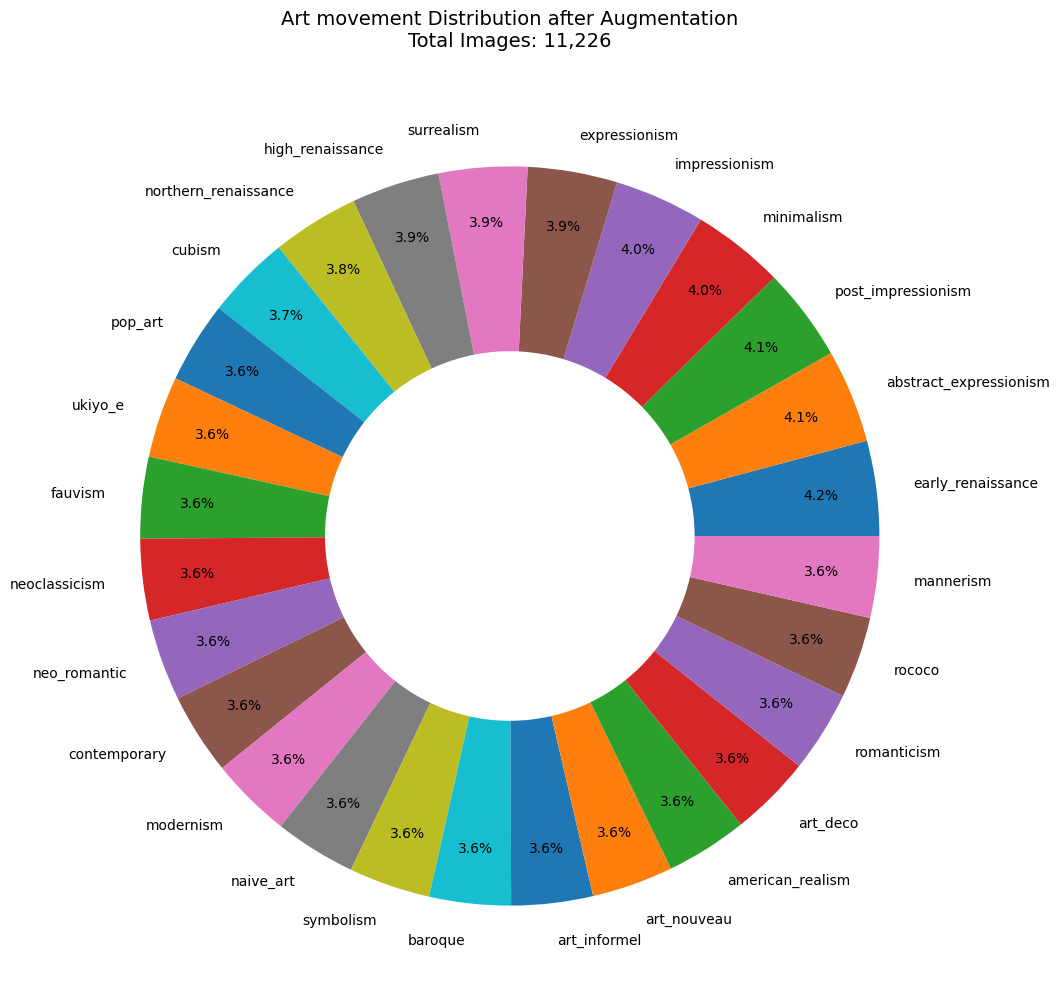

In [19]:
def plot_movement_pie(df):
    """
    Creates a pie chart of art movement distribution using matplotlib
    """
    plt.figure(figsize=(12, 12))
    
    # Get movement counts and total
    movement_counts = df['movement'].value_counts()
    total_images = len(df)
    
    # Create pie chart
    plt.pie(movement_counts.values, 
            labels=movement_counts.index,
            autopct='%1.1f%%',
            pctdistance=0.85,
            wedgeprops=dict(width=0.5))  # Creates donut effect
    
    plt.title(f"Art movement Distribution after Augmentation\nTotal Images: {total_images:,}", 
              pad=20, 
              size=14)
    
    return plt

#Usage:
plot_movement_pie(verified_df)
plt.show()

In [20]:
verified_df.columns

Index(['id', 'title', 'url', 'artistUrl', 'artistName', 'artistId',
       'completitionYear', 'width', 'image', 'height', 'movement', 'file_path',
       'image_array'],
      dtype='object')

In [21]:
# Drop columns we don't need. We'll keep the file_path
# and process the images into arrays during training.
training_imageset = verified_df.drop(columns=['id', 'title', 'url', 'artistUrl', 'artistName', 'artistId',
       'completitionYear', 'width', 'image', 'height', 'image_array'], axis=1)

# Verify the new structure
training_imageset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11226 entries, 0 to 11225
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   movement   11226 non-null  object
 1   file_path  11226 non-null  object
dtypes: object(2)
memory usage: 175.5+ KB


In [22]:
training_imageset.to_csv('training_imageset2.csv', index=False)